In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy.random as r
from pylab import *
from matplotlib.gridspec import GridSpec

import sys
sys.path.insert(0, '../../utils')
import splicing_utils as spu
import single_cell_plots as scp
from single_cell_plots import *

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"


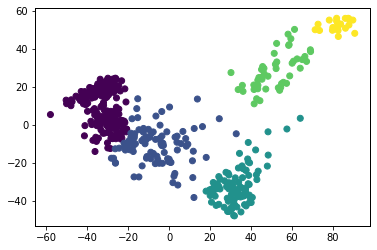

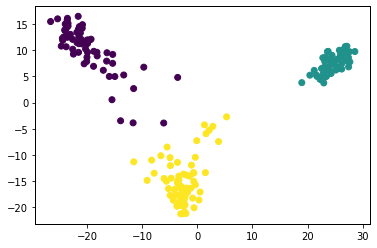

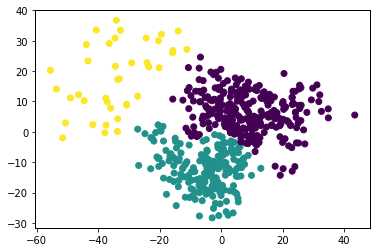

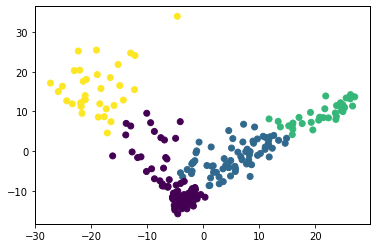

In [6]:
%run -i 'load_data.py'

In [7]:
# import importlib
# importlib.reload(scp)
# importlib.reload(spu)
# sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"

In [8]:
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import rpy2
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri as rpyn
from statsmodels.stats.multitest import multipletests
dt = rpy2.robjects.packages.importr('diptest')

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.special import logit
from scipy.special import expit

from sklearn.metrics import adjusted_rand_score

from scipy.stats import chisquare

In [9]:
chen_selected_exons = []
for clust in chen_clust_filter:
    chen_selected_exons.extend(list(clust[0].index))
    
chen_selected_exons = sorted(set(chen_selected_exons))

aver = filter_psi(chen_PSI.loc[chen_selected_exons], chen_selected_exons, mrna_per_event_chen, chen_coverage_tab['SJ_coverage'],
          chen_read_counts, 10, 0, 0)

aver_total_ = aver[0].T.corr().index
aver_total_ = aver_total_[aver[0].loc[aver_total_].T.corr().isna().mean(axis=1) <= 0.01]
#aver[0].loc[aver_total_]


aver_filtered_ = []
aver_filtered_basura_ = []
for x in aver_total_:
    if x.split('_')[:-1] not in aver_filtered_basura_:
        aver_filtered_.append(x)
        aver_filtered_basura_.append(x.split('_')[:-1])

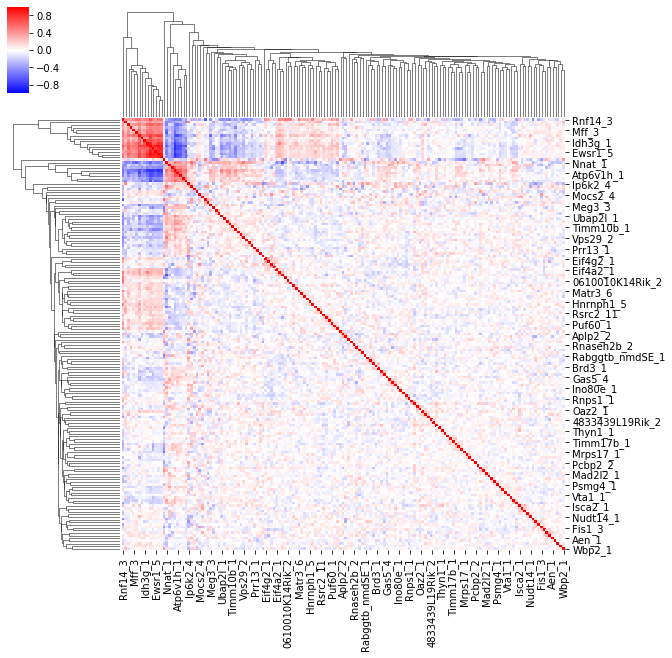

In [10]:
figsize(4,4)
sns.clustermap(aver[0].loc[aver_filtered_].T.corr(), cmap=cm.bwr, vmin=-1, vmax=1)
plt.show()

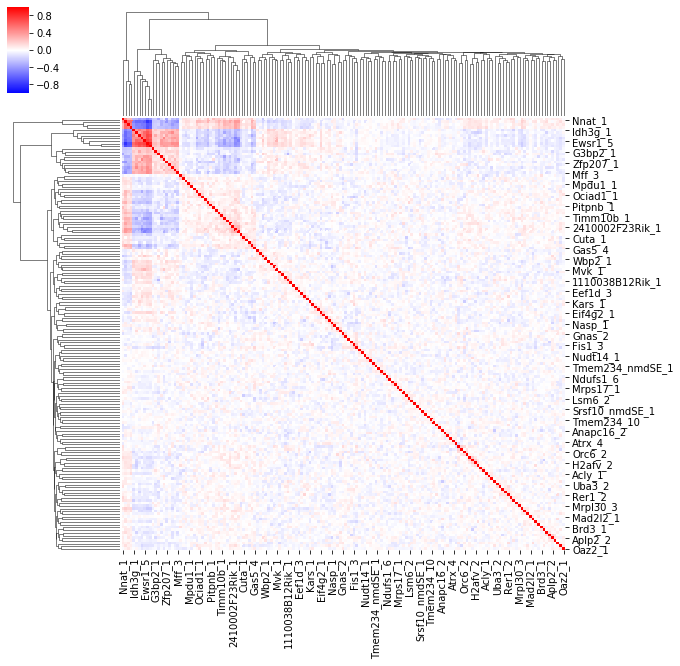

In [11]:
from scipy.stats import zscore
aver_finale = aver[0].loc[aver_filtered_]#
aver_finale = pd.DataFrame(zscore(aver_finale.T.fillna(aver_finale.T.mean()).T))
aver_finale.columns = aver[0].columns
aver_finale.index = aver_filtered_

sns.clustermap(aver_finale.loc[aver_filtered_].T.corr(), cmap=cm.bwr, vmin=-1, vmax=1)
plt.show()

In [12]:
# chen_MN_int_genes, chen_MN_int_exons = spu.get_int_events(chen_PSI[chen_MN], chen_mrna_counts[chen_MN], 0.2)

# aver = filter_psi(chen_PSI[chen_MN], chen_MN_int_exons, mrna_per_event_chen[chen_MN], 
#                   chen_coverage_tab.loc[chen_MN, 'SJ_coverage'],
#                   chen_read_counts[chen_MN], 10, 0, 0.5)

# aver_total_ = aver[0].T.corr().index
# aver_total_ = aver_total_[aver[0].loc[aver_total_].T.corr().isna().mean(axis=1) <= 0.01]
# #aver[0].loc[aver_total_]


# aver_filtered_ = []
# aver_filtered_basura_ = []
# for x in aver_total_:
#     if x.split('_')[:-1] not in aver_filtered_basura_:
#         aver_filtered_.append(x)
#         aver_filtered_basura_.append(x.split('_')[:-1])

In [13]:
# figsize(4,4)
# sns.clustermap(aver[0].loc[aver_filtered_].T.corr(), cmap=cm.bwr, vmin=-1, vmax=1)
# plt.show()

In [107]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi[1] >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
    if correct_multitest:
        pvals_adj = multipletests(pvals, method=correction)[1]
    else:
        pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals_adj


def cluster_fisher_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_fisher(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
    if correct_multitest:
        pvals_adj = multipletests(pvals, method=correction)[1]
    else:
        pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals_adj
    
    
    
def test_exon_chi(PSI_tab, exon, clusters, psi_lim = 0.5):
    chi_pos = []
    chi_neg = []
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= psi_lim).sum()
        missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
        neg_cases = len(cluster_cells) - pos_cases - missing
        
        chi_pos.append(pos_cases)
        chi_neg.append(neg_cases)
        
#     print(chi_pos)
#     print(chi_neg)
        
    return chisquare(chi_pos, chi_neg), np.array(chi_pos), np.array(chi_neg)


def test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = 0.25):
    
    psi_mean = PSI_tab.loc[exon].mean()
    chi_pos = []
    chi_exp = []
    chi_neg = []
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
        #missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
        neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
        expected_pos = (pos_cases + neg_cases) * psi_mean
        
        
        chi_pos.append(pos_cases)
        chi_exp.append(expected_pos)
        chi_neg.append(neg_cases)
        
        
    return chisquare(chi_pos, chi_exp)[1], np.array(chi_pos), np.array(chi_neg), np.array(chi_exp)



def test_exon_bimodal_fisher(PSI_tab, exon, clusters, psi_lim = 0.25):
    
    psi_mean = PSI_tab.loc[exon].mean()
    chi_pos = []
    chi_exp = []
    chi_neg = []
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
        #missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
        neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
        expected_pos = (pos_cases + neg_cases) * psi_mean
        
        
        chi_pos.append(pos_cases)
        chi_exp.append(expected_pos)
        chi_neg.append(neg_cases)
        
    ftest_p = stats.fisher_test(np.array([chi_pos, chi_neg]))[0][0]
        
    return ftest_p, np.array(chi_pos), np.array(chi_neg), np.array(chi_exp)

In [15]:
# def test_exon_chi(PSI_tab, exon, clusters, psi_lim = 0.5):
#     chi_pos = []
#     chi_neg = []
#     for clust in clusters.unique():
#         cluster_cells = clusters.loc[clusters == clust].index
        
#         pos_cases = (PSI_tab.loc[exon, cluster_cells] >= psi_lim).sum()
#         missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
#         neg_cases = len(cluster_cells) - pos_cases - missing
        
#         chi_pos.append(pos_cases)
#         chi_neg.append(neg_cases)
        
# #     print(chi_pos)
# #     print(chi_neg)
        
#     return chisquare(chi_pos, chi_neg), np.array(chi_pos), np.array(chi_neg)


# def test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = 0.25):
    
#     psi_mean = PSI_tab.loc[exon].mean()
#     chi_pos = []
#     chi_exp = []
#     chi_neg = []
#     for clust in clusters.unique():
#         cluster_cells = clusters.loc[clusters == clust].index
        
#         pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
#         #missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
#         neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
#         expected_pos = (pos_cases + neg_cases) * psi_mean
        
        
#         chi_pos.append(pos_cases)
#         chi_exp.append(expected_pos)
#         chi_neg.append(neg_cases)
        
        
#     return chisquare(chi_pos, chi_exp), np.array(chi_pos), np.array(chi_neg), np.array(chi_exp)

In [16]:
from scipy.stats import hypergeom
def hyper_test(M, n, N, k):
    
    hpd = hypergeom(M, n, N)
    p_depleted = hpd.cdf(k)
    p_enriched = hpd.sf(k-1)
    
    return p_depleted, p_enriched

In [17]:
from scipy.stats import probplot

In [184]:
def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, obs_min)
    
    
    # Events that do not pass the filter
    
    change_tab_all, chi_p_all = cluster_chi_test(PSI_tab.loc[int_exons], clusters, psi_bin)
    
    unfiltered_exons = [x for x in int_exons if x not in aver[0].index]
    change_tab_uf, chi_p_uf = cluster_chi_test(PSI_tab.loc[unfiltered_exons], clusters, psi_bin)
    
    unfiltered_exons_r = [x for x in int_exons if x not in aver_reads[0].index]
    change_tab_ufr, chi_p_ufr = cluster_chi_test(PSI_tab.loc[unfiltered_exons_r], clusters, psi_bin)
    
    change_tab_aver, chi_p_aver = cluster_chi_test(aver[0], clusters, psi_bin)
    change_tab_nofilt, chi_p_nofilt = cluster_chi_test(PSI_tab.loc[aver[0].index], clusters, psi_bin)
    change_tab_averr, chi_p_averr = cluster_chi_test(aver_reads[0], clusters, psi_bin)

    figsize(8, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of $\chi^2$ test')

    gs = GridSpec(6,10)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
#     ax_marg_x5 = fig.add_subplot(gs[0:6,9])
    
    ax_joint.scatter(probplot(chi_p_aver)[0][0], probplot(chi_p_aver)[0][1], alpha = 0.75, c='navy', label='joint filter')
    ax_joint.scatter(probplot(chi_p_averr)[0][0], probplot(chi_p_averr)[0][1], alpha = 0.75, c='darkred', label='read filter')
    ax_joint.scatter(probplot(chi_p_all)[0][0], probplot(chi_p_all)[0][1], alpha = 0.75, c='forestgreen', label='all exons')
    ax_joint.scatter(probplot(chi_p_uf)[0][0], probplot(chi_p_uf)[0][1], alpha = 0.75, c='purple', label='rejected')
#     ax_joint.scatter(probplot(chi_p_ufr)[0][0], probplot(chi_p_ufr)[0][1], alpha = 0.2, c='darkorange')
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(chi_p_aver, orientation="horizontal", color='navy')
    ax_marg_x2.hist(chi_p_averr, orientation="horizontal", color='darkred')
    ax_marg_x3.hist(chi_p_all, orientation="horizontal", color='forestgreen')
    ax_marg_x4.hist(chi_p_uf, orientation="horizontal", color='purple')
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
#     ax_marg_x5.hist(chi_p_ufr, orientation="horizontal", color='darkrorange')

    ax_joint.set_xlabel('adjusted p-value')
    ax_joint.set_ylabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    
def test_fisher_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, print_extreme=False):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, obs_min)
    
    
    # Events that do not pass the filter
    
    change_tab_all, chi_p_all = cluster_fisher_test(PSI_tab.loc[int_exons], clusters, psi_bin, print_extreme = print_extreme)
    
    unfiltered_exons = [x for x in int_exons if x not in aver[0].index]
    change_tab_uf, chi_p_uf = cluster_fisher_test(PSI_tab.loc[unfiltered_exons], clusters, psi_bin, 
                                                  print_extreme = print_extreme)
    
    unfiltered_exons_r = [x for x in int_exons if x not in aver_reads[0].index]
    change_tab_ufr, chi_p_ufr = cluster_fisher_test(PSI_tab.loc[unfiltered_exons_r], clusters, psi_bin,
                                                    print_extreme = print_extreme)
    
    change_tab_aver, chi_p_aver = cluster_fisher_test(aver[0], clusters, psi_bin)
    change_tab_nofilt, chi_p_nofilt = cluster_fisher_test(PSI_tab.loc[aver[0].index], clusters, psi_bin, 
                                                          print_extreme = print_extreme)
    change_tab_averr, chi_p_averr = cluster_fisher_test(aver_reads[0], clusters, psi_bin, print_extreme = print_extreme)

    figsize(8, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of Fisher test')

    gs = GridSpec(6,10)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
#     ax_marg_x5 = fig.add_subplot(gs[0:6,9])
    
    ax_joint.scatter(probplot(chi_p_aver)[0][0], probplot(chi_p_aver)[0][1], alpha = 0.75, c='navy', label='joint filter')
    ax_joint.scatter(probplot(chi_p_averr)[0][0], probplot(chi_p_averr)[0][1], alpha = 0.75, c='darkred', label='read filter')
    ax_joint.scatter(probplot(chi_p_all)[0][0], probplot(chi_p_all)[0][1], alpha = 0.75, c='forestgreen', label='all exons')
    ax_joint.scatter(probplot(chi_p_uf)[0][0], probplot(chi_p_uf)[0][1], alpha = 0.75, c='purple', label='rejected')
#     ax_joint.scatter(probplot(chi_p_ufr)[0][0], probplot(chi_p_ufr)[0][1], alpha = 0.2, c='darkorange')
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(chi_p_aver, orientation="horizontal", color='navy')
    ax_marg_x2.hist(chi_p_averr, orientation="horizontal", color='darkred')
    ax_marg_x3.hist(chi_p_all, orientation="horizontal", color='forestgreen')
    ax_marg_x4.hist(chi_p_uf, orientation="horizontal", color='purple')
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
#     ax_marg_x5.hist(chi_p_ufr, orientation="horizontal", color='darkrorange')

    ax_joint.set_xlabel('adjusted p-value')
    ax_joint.set_ylabel('Normal theoratical quantiles')
    ax_joint.legend(frameon=False)
    
    plt.show()

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


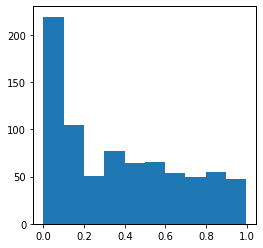

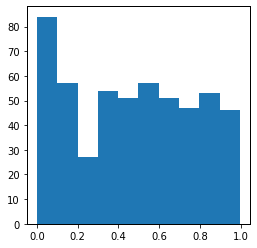

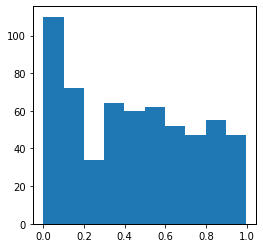

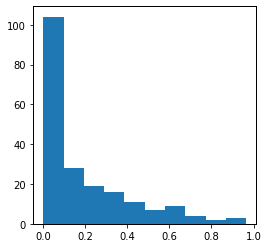

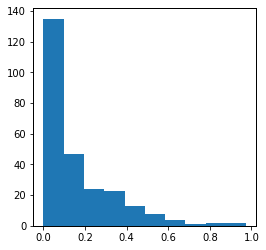

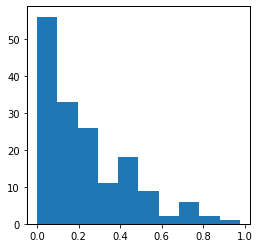

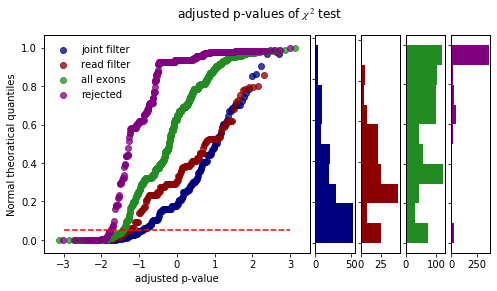

In [185]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min = 6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


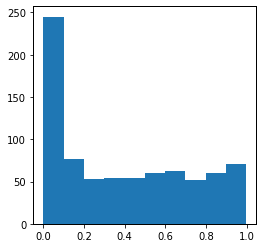

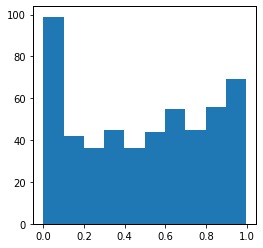

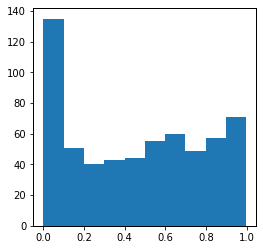

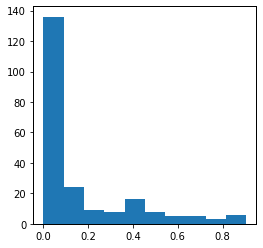

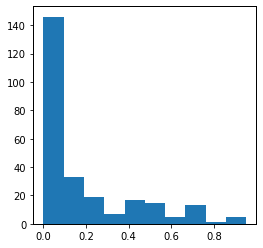

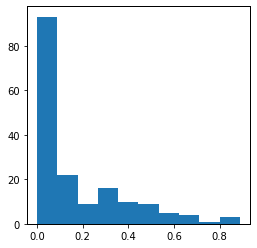

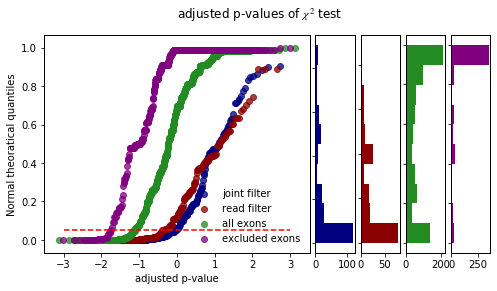

In [160]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min = 6)

In [161]:
test_fisher_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 6, read_min = 6)

load_data.py:40: RuntimeWarning: invalid value encountered in true_divide
  sep='\t',  index_col=0)
R[write to console]: Error in (function (x, y = NULL, workspace = 2e+05, hybrid = FALSE, hybridPars = c(expect = 5,  : 
  FEXACT error 7(location). LDSTP=18600 is too small for this problem,
  (pastp=49.2715, ipn_0:=ipoin[itp=186]=227, stp[ipn_0]=46.913).
Increase workspace or consider using 'simulate.p.value=TRUE'



RRuntimeError: Error in (function (x, y = NULL, workspace = 2e+05, hybrid = FALSE, hybridPars = c(expect = 5,  : 
  FEXACT error 7(location). LDSTP=18600 is too small for this problem,
  (pastp=49.2715, ipn_0:=ipoin[itp=186]=227, stp[ipn_0]=46.913).
Increase workspace or consider using 'simulate.p.value=TRUE'


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


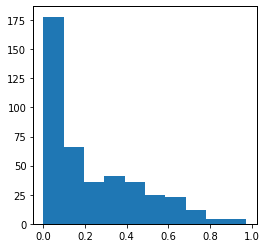

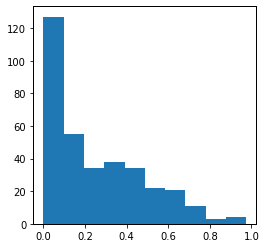

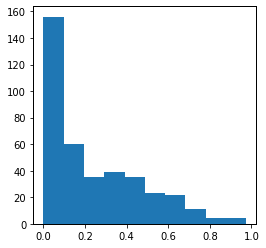

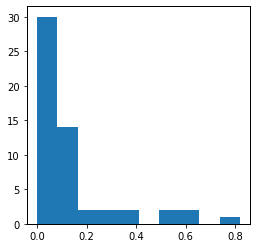

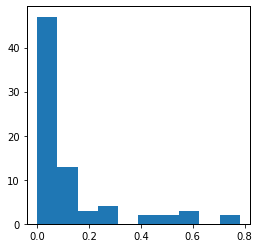

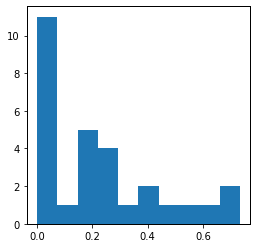

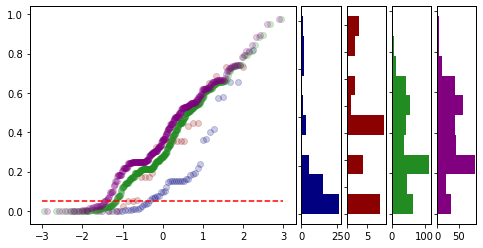

In [44]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.5, mrna_min = 10, read_min = 10)

In [31]:
# test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.cell_type, 
#                      psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min = 6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


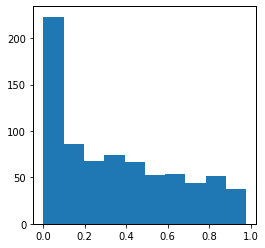

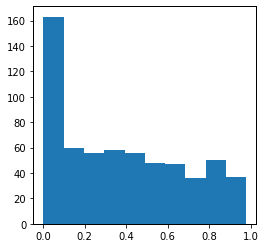

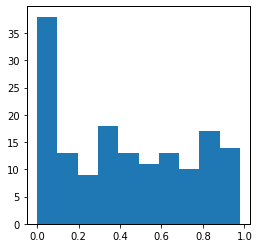

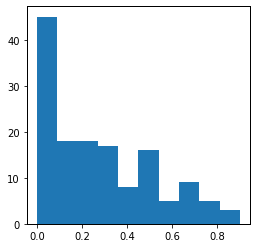

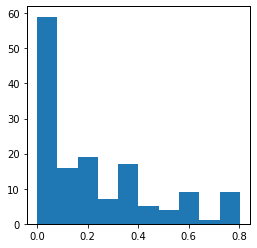

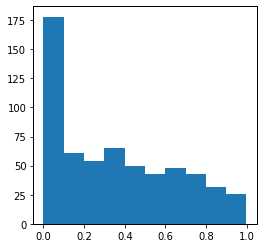

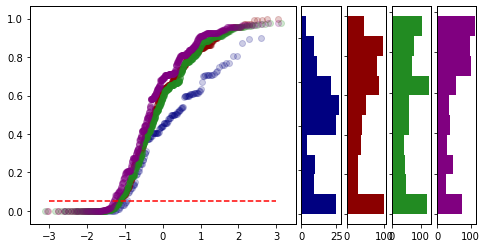

In [33]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min = 6)

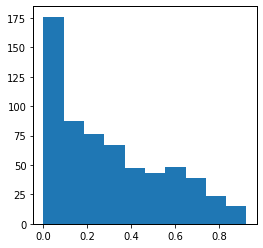

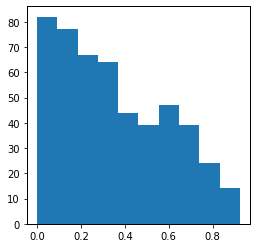

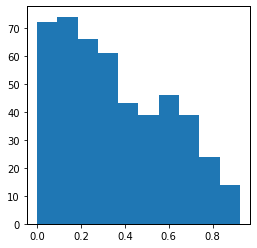

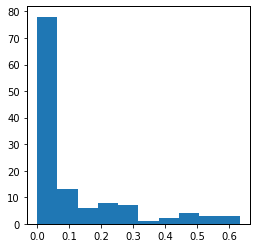

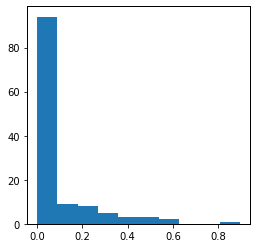

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


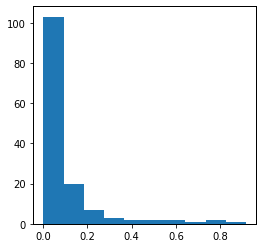

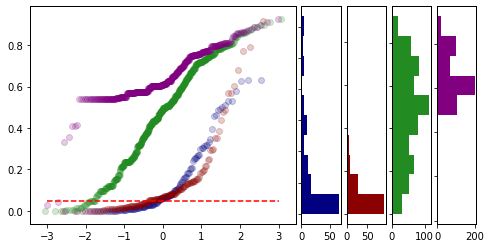

In [34]:
test_chi_filters(lescroart_PSI, lescroart_mrna_counts, mrna_per_event_lescroart, lescroart_read_counts, lescroart_coverage_tab, lescroart_pca_clust.cell_type, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min = 6)

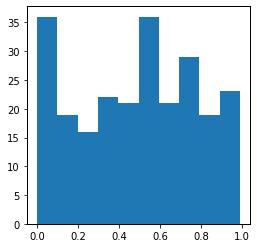

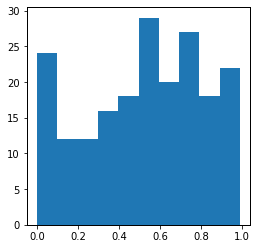

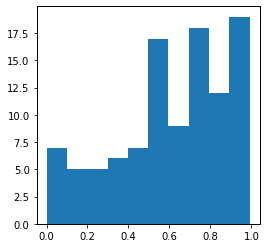

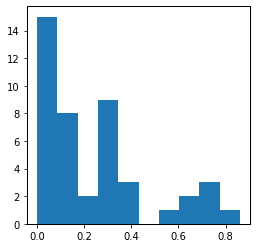

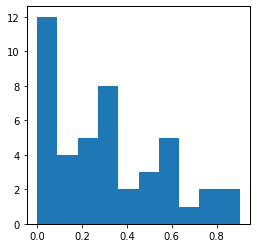

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


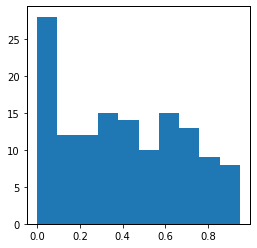

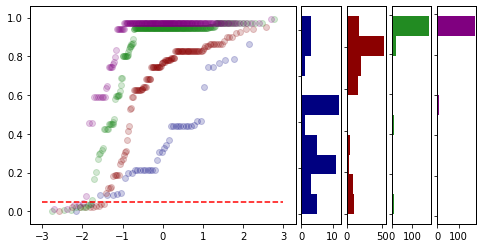

In [45]:
test_chi_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, trapnell_coverage_tab, trapnell_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.5, mrna_min = 6, read_min = 6)

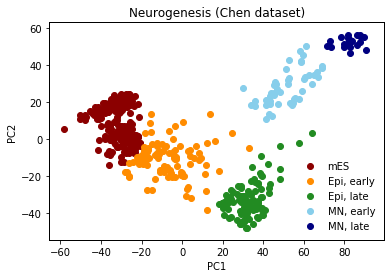

In [61]:
figsize(6, 4)
plt.scatter(chen_pca_clust.loc[chen_pca_clust.AC==0, 'PC1'], 
            chen_pca_clust.loc[chen_pca_clust.AC==0, 'PC2'], c='darkred', label='mES')
plt.scatter(chen_pca_clust.loc[chen_pca_clust.AC==1, 'PC1'], 
            chen_pca_clust.loc[chen_pca_clust.AC==1, 'PC2'], c='darkorange', label='Epi, early')
plt.scatter(chen_pca_clust.loc[chen_pca_clust.AC==2, 'PC1'], 
            chen_pca_clust.loc[chen_pca_clust.AC==2, 'PC2'], c='forestgreen', label='Epi, late')
plt.scatter(chen_pca_clust.loc[chen_pca_clust.AC==3, 'PC1'], 
            chen_pca_clust.loc[chen_pca_clust.AC==3, 'PC2'], c='skyblue', label='MN, early')
plt.scatter(chen_pca_clust.loc[chen_pca_clust.AC==4, 'PC1'], 
            chen_pca_clust.loc[chen_pca_clust.AC==4, 'PC2'], c='navy', label='MN, late')
plt.title('Neurogenesis (Chen dataset)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(frameon=False)
plt.show()

In [56]:
chen_pca_clust.loc['SRR2727109', 'AC']

0

In [63]:
import numpy as np
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

stats = importr('stats')
m = np.array([[4,4],[4,5],[10,6]])
res = stats.fisher_test(m)
print ('p-value: {}'.format(res[0][0]))

p-value: 0.6643639131198411


In [89]:
stats.fisher_test( np.array([[140,1],[121,2],[110,6], [110,2], [110,1]]))[0][0]

0.15445024327073673

In [99]:
stats.fisher_test(np.array([[140,1],[121,2],[110,6], [110,2], [110,1]]).T)[0][0]

0.15445024327073673

In [114]:
observed = chen_PSI.loc[chen_PSI.isna().mean(axis=1) <= (1-0.5)].index
chen_int_genes, chen_int_exons = spu.get_int_events(chen_PSI.loc[observed], chen_mrna_counts, 0.2)
    
aver = filter_psi(chen_PSI, chen_int_exons, mrna_per_event_chen, chen_coverage_tab['SJ_coverage'],
          chen_read_counts, 10, 0, 0.5)

# change_tab_all, chi_p_all = cluster_fisher_test(PSI_tab.loc[int_exons], clusters, psi_bin, print_extreme = print_extreme)

chen_unfiltered_exons = [x for x in chen_int_exons if x not in aver[0].index]

In [125]:
aver[0].index

Index(['0610010K14Rik_3', '0610010K14Rik_4', '1110038B12Rik_1',
       '2610318N02Rik_1', 'Anapc16_2', 'Atrx_4', 'Bclaf1_3', 'Cenpa_6',
       'Cenpa_nmdSE_1', 'Chtop_2', 'Clk1_1', 'Csde1_6', 'Cuedc2_1', 'Cuta_1',
       'Dph3_2', 'Eif4a2_1', 'Eif4e2_1', 'Eif4h_1', 'Erh_1', 'Fmr1nb_1',
       'Fxr1_1', 'G3bp2_1', 'Gas5_4', 'Hnrnpa2b1_1', 'Hnrnpa2b1_2',
       'Hnrnpab_1', 'Hnrnpc_1', 'Hnrnpd_3', 'Idh3g_1', 'Ift20_1', 'Immt_1',
       'Lsm6_2', 'Mff_3', 'Mrpl24_1', 'Mrpl30_3', 'Mrps17_1', 'Mrps17_4',
       'Mtf2_2', 'Mtf2_3', 'Nap1l4_1', 'Nsfl1c_2', 'Ociad1_1', 'Pcbp2_7',
       'Pla2g1b_1', 'Psmg4_1', 'Ptbp1_6', 'Puf60_1', 'Rabggtb_nmdSE_1',
       'Rbm39_nmdSE_2', 'Rer1_2', 'Rer1_3', 'Rnaseh2b_1', 'Rnps1_1',
       'Rsrc2_11', 'Rsrc2_6', 'Rsrp1_1', 'Smarcad1_3', 'Syce2_2', 'Tex30_5',
       'Thyn1_1', 'Timm9_2', 'Tmem134_1', 'Tmem234_nmdSE_1', 'Tor1aip2_3',
       'Tpd52l2_4', 'Tpd52l2_7', 'U2af1l4_6', 'U2surp_1', 'Ubap2l_3',
       'Ube2i_1', 'Ube2i_2', 'Vps29_2', 'Wfdc2_1', 'Wfdc2_

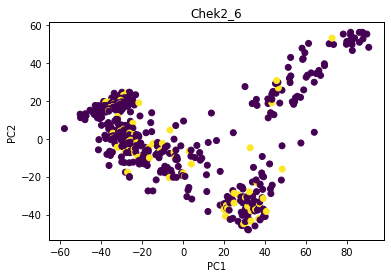

In [135]:
figsize(6, 4)
plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c=(chen_PSI.loc['Chek2_6']>=0.75))#, cmap=cm.viridis)

plt.title('Chek2_6')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

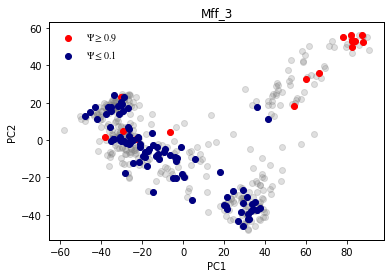

In [187]:
colores = []
pc1_i = []
pc2_i = []
pc1_e = []
pc2_e = []
for cell in chen_PSI.columns:
    if aver[0].loc['Mff_3', cell] >= 0.9:
        colores.append('red')
        pc1_i.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_i.append(chen_pca_clust.loc[cell, 'PC2'])
    elif aver[0].loc['Mff_3', cell] <= 0.1:
        colores.append('darkblue')
        pc1_e.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_e.append(chen_pca_clust.loc[cell, 'PC2'])
    
        
figsize(6, 4)
plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c='grey', alpha=0.25)#, cmap=cm.viridis)
plt.scatter(pc1_i, pc2_i, c='red', label = '$\Psi \geq 0.9$')
plt.scatter(pc1_e, pc2_e, c='navy', label = '$\Psi \leq 0.1$')
plt.title('Mff_3')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(frameon=False)
plt.show()

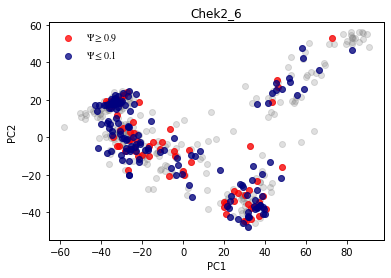

In [167]:
figsize(6, 4)

colores = []

    
pc1_i = []
pc2_i = []
pc1_e = []
pc2_e = []
for cell in chen_PSI.columns:
    if chen_PSI.loc['Chek2_6', cell] >= 0.9:
        colores.append('red')
        pc1_i.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_i.append(chen_pca_clust.loc[cell, 'PC2'])
    elif chen_PSI.loc['Chek2_6', cell] <= 0.1:
        colores.append('darkblue')
        pc1_e.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_e.append(chen_pca_clust.loc[cell, 'PC2'])
    
        
figsize(6, 4)
plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c='grey', alpha=0.25)#, cmap=cm.viridis)
plt.scatter(pc1_i, pc2_i, c='red', label = '$\Psi \geq 0.9$', alpha=0.75)
plt.scatter(pc1_e, pc2_e, c='navy', label = '$\Psi \leq 0.1$', alpha=0.75)
plt.title('Chek2_6')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(frameon=False)

plt.show()

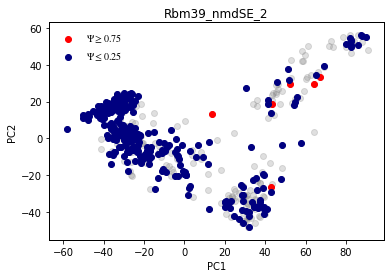

In [155]:
colores = []
pc1_i = []
pc2_i = []
pc1_e = []
pc2_e = []
for cell in chen_PSI.columns:
    if aver[0].loc['Rbm39_nmdSE_2', cell] >= 0.75:
        colores.append('red')
        pc1_i.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_i.append(chen_pca_clust.loc[cell, 'PC2'])
    elif aver[0].loc['Rbm39_nmdSE_2', cell] <= 0.25:
        colores.append('darkblue')
        pc1_e.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_e.append(chen_pca_clust.loc[cell, 'PC2'])
    
        
figsize(6, 4)
plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c='grey', alpha=0.25)#, cmap=cm.viridis)
plt.scatter(pc1_i, pc2_i, c='red', label = '$\Psi \geq 0.75$')
plt.scatter(pc1_e, pc2_e, c='navy', label = '$\Psi \leq 0.25$')
plt.title('Rbm39_nmdSE_2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(frameon=False)
plt.show()

In [176]:
chisquare([0, 20, 0], [3, 21, 1])

Power_divergenceResult(statistic=4.0476190476190474, pvalue=0.1321510722856143)